<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PAC3</p>
<p style="margin: 0; text-align:right;">2021-1 · Máster universitario en Ciencia de datos (<i>Data science</i>)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación
</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PAC 3: Métodos supervisados

En esta práctica veremos diferentes métodos supervisados y trataremos de optimizar diferentes métricas. Veremos cómo los diferentes modelos clasifican los puntos y con cuáles obtenemos mayor precisión. Después aplicaremos todo lo que hemos aprendido hasta ahora a un conjunto de datos nuevo simulando un caso práctico real.

1. Exploración de algoritmos supervisados
       1.1. K vecinos más cercanos
       1.2. Support vector machines
       1.3. Árbol de decisión
       1.4. Random forest
       1.5. Gradient boosting
2. Implementación de un caso práctico
       2.1. Análisis descriptivo
       2.2. Preprocesamiento de los datos
       2.3. Entrenamiento de un modeo
       2.4. Predicción de casos nuevos

**Importante: Cada uno de los ejercicios puede suponer varios minutos de ejecución, por lo que la entrega se ha de hacer en formato notebook y en formato html, donde se vea el código y los resultados junto con los comentarios de cada ejercicio. Para exportar el notebook a html se puede hacer desde el menú File $\to$ Download as $\to$ HTML.**

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos:</strong> Javier Gómez de Diego
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import seaborn as sns
from sklearn import svm
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

%matplotlib inline

## 1. Carga de datos

El conjunto de datos MOONS consiste en puntos en un plano que forman dos lunas, de ahí el nombre de "moons". Cada luna se corresponde a un grupo diferente [0, 1].

El siguiente código generará 1.000 puntos y hará un gráfico para visualizar las dos lunas con colores diferentes para cada grupo.

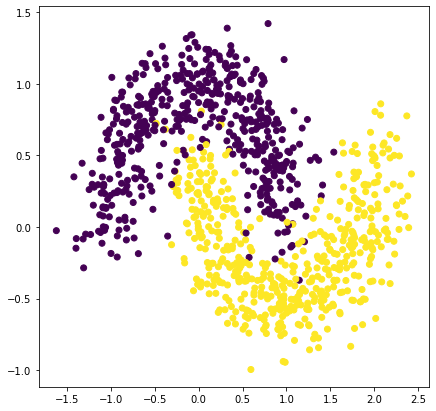

In [2]:
df = make_moons(n_samples=1000, noise=0.2, random_state=2)
df_x = [x[0] for x in df[0]]
df_y = [x[1] for x in df[0]]
df_group = df[1]

fig, ax = plt.subplots(figsize=(7,7))
ax.scatter(df_x, df_y, c=df_group)

Antes de aplicar ningún modelo, hemos de separar los datos entre el conjunto de *train* y el conjunto de *test*. Siempre trabajaremos sobre el conjunto de *train* y evaluaremos los resultados en *test*.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> divide el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% aprox.) y <i>test</i>. Puedes servirte de <i>train_test_split</i>, ya implementado en <i>sklearn</i>.
</div>

In [3]:
# Normalizar y dividir el dataset
from sklearn import preprocessing
normalizar = preprocessing.MinMaxScaler()
X = normalizar.fit_transform(df[0])
X_train, X_test, y_train, y_test = train_test_split(X, df[1], train_size = 0.8)

A lo largo de los ejercicios veremos gráficamente las fronteras de decisión asociadas a cada uno de los diferentes modelos. Para hacerlo utilizaremos la función definida a continuación. Dicha función sigue los siguientes pasos:

- Crear una [meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) con los valores mínimos y máximos de 'x' e 'y'.
- Predecir con el clasificador los valores de la *meshgrid*.
- Hacer un *reshape* de los datos para tener el formato correspondiente.

Una vez hecho esto, ya podemos crear el gráfico de las fronteras de decisión y añadirle los puntos reales.
Así, veremos las áreas que el modelo considera que son de una clase y las que considera que son de otra. De esta forma, comprobaremos si el modelo clasifica los puntos correctamente dentro del área que les corresponde. También detectaremos las áreas de incertidumbre, casos en los que el modelo no se decanta ni por una clase ni por la otra (o si sí que se decanta por una pero no lo tiene 100% claro), éstas áreas serán blanquecinas.

In [4]:
# Hacemos la meshgrid con los valores máximos y mínimos de 'x' e 'y'.
x_min, x_max = min(df_x)-0.1, max(df_x)+0.1
y_min, y_max = min(df_y)-0.1, max(df_y)+0.1  

def plot_decision_boundaries(x, y, labels, model, 
                             x_min=x_min, 
                             x_max=x_max, 
                             y_min=y_min, 
                             y_max=y_max, 
                             grid_step=0.02):
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))
    
    # Predecimos los valores de la meshgrid con el clasificador.
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,1]

    # Hacemos el reshape para tener el formato correcto.
    Z = Z.reshape(xx.shape)

    # Seleccionamos una paleta de color.
    arr = plt.cm.coolwarm(np.arange(plt.cm.coolwarm.N))
    arr_hsv = mpl.colors.rgb_to_hsv(arr[:,0:3])
    arr_hsv[:,2] = arr_hsv[:,2] * 1.5
    arr_hsv[:,1] = arr_hsv[:,1] * .5
    arr_hsv = np.clip(arr_hsv, 0, 1)
    arr[:,0:3] = mpl.colors.hsv_to_rgb(arr_hsv) 
    my_cmap = ListedColormap(arr)
    
    # Creamos el gráfico con las fronteras de decisión.
    fig, ax = plt.subplots(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=my_cmap, shading='auto')

    # Añadimos los puntos.
    ax.scatter(x, y, c=labels, cmap='coolwarm')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.grid(False)

### 1.1 $K$ vecinos más cercanos (1 punto)

El primer algoritmo que utilizaremos para clasificar los puntos es el $k$-nn. En este ejercicio, ajustaremos dos hiperparámetros del algoritmo con la intención de obtener una mayor precisión:

- $k$: el número de vecinos que se considera para clasificar un nuevo ejemplo. Probaremos con todos los valores entre 1 y 10.
- pesos: importancia que se da a cada uno de los vecinos considerados. En este caso, jugaremos con dos opciones: pesos uniformes, donde todos los vecinos se consideran de igual manera; y pesos en función de la distancia, donde los vecinos más cercanos tienen más peso en la clasificación que los vecinos más lejanos.

Para decidir cuáles son los hiperparámetros óptimos utilizaremos la técnica de búsqueda conocida como *grid search*, con la que entrenaremos un modelo para cada combinación de hiperparámetros posible y la evaluaremos utilizando validación cruzada (*cross validation*) con 4 particiones estratificadas. Posteriormente, elegiremos la combinación de hiperparámetres que mejores resultados haya obtenido.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>k</i> y <i>pesos</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y KNeighborsClassifier de sklearn.
</div>

In [5]:
# Normalizar
from sklearn import preprocessing
normalizar = preprocessing.MinMaxScaler()
X = normalizar.fit_transform(df[0])
X_train, X_test, y_train, y_test = train_test_split(X, df[1], train_size = 0.8)

In [6]:
# Instanciar knn y establecer rango de parámetros
knn = KNeighborsClassifier()
parametros = {
    'n_neighbors':list(range(1, 11)),
    'weights':['uniform', 'distance']
}

# Instanciar GridSearch con el rango de parámetros definido y ajustar
knn_grid = GridSearchCV(knn, parametros, cv = 4)
knn_grid.fit(X_train, y_train)

# Obtener mejor combinación de parámetros
print('La mejor pareja de parámetros es:\nk =', knn_grid.best_params_['n_neighbors'], '\npesos =', knn_grid.best_params_['weights'])

La mejor pareja de parámetros es:
k = 6 
pesos = distance


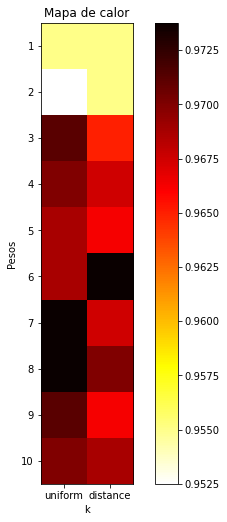

In [7]:
# Obtener todos los resultados decada una de las combinaciones de parámetros
r = knn_grid.cv_results_['mean_test_score'].reshape(len(parametros['n_neighbors']),len(parametros['weights']))

# Graficar
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(r, cmap='hot_r')
plt.xlabel('k')
plt.ylabel('Pesos')
plt.colorbar()
plt.yticks(np.arange(len(parametros['n_neighbors'])), parametros['n_neighbors'])
plt.xticks(np.arange(len(parametros['weights'])), parametros['weights'])
plt.title('Mapa de calor')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

La precisión del modelo es 0.9690721649484536


,Predicción 0,Predicción 1
Real 0,94,3
Real 1,5,98


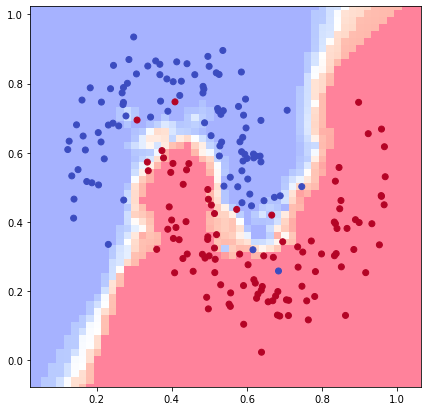

In [8]:
# Instanciar knn con la mejor combinación de parámetros
knn = KNeighborsClassifier(n_neighbors = knn_grid.best_params_['n_neighbors'], weights = knn_grid.best_params_['weights'])

# Entrenar con los datos de train
knn.fit(X_train, y_train)

# Graficar fronteras de decisión
test = pd.DataFrame(X_test)
plot_decision_boundaries(test[0], test[1], y_test, knn,
                         x_max=max(test[0]) + 0.1,
                         x_min=min(test[0]) - 0.1,
                         y_max=max(test[1]) + 0.1,
                         y_min=min(test[1]) - 0.1
                        )

# Obtener predicción con los datos de test y evaluar
p = knn.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, p), ['Real 0', 'Real 1'], ['Predicción 0', 'Predicción 1'])
print('La precisión del modelo es', cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1]))
cm

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532><b><i>knn</i></b> ha conseguido clasificar correctamente la mayor parte de los datos de <i>test</i>.<br>

<font color=#679532>En cuanto a la frontera de decisión, lo primero que se observa es que no es lineal. Su geometría se adapta a la de los datos de forma que puede dividir las dos clases. También se puede ver la zona de incertidumbre, que se hace bastante irregular especialmente en los cambios de pendiente de la frontera de decisión y que no se encuentra muy bien definida (es algo difusa). Esto hace que las instancias que caen en este área sean potencialmente clasificadas de forma errónea. Se puede apreciar cómo la zona de incertidumbre se sitúa donde se encuentran los puntos más difíciles de clasificar de forma intuitiva.
</div>

### 1.2. Support Vector Machines (1 punto)

En este segundo ejercicio, clasificaremos los puntos utilizando el algoritmo SVM con el *kernel* radial. Volveremos a utilizar *grid search*. En este caso los hiperparámetros a optimizar son:

- C: regularización, es decir, el valor de penalización de los errores en la clasificación. Indica el compromiso entre obtener el hiperplano con el margen más grande posible y clasificar el máximo número de ejemplos correctamente. Probaremos los valores: 0.01, 0.1, 1, 10, 50, 100 y 200.
- gamma: coeficiente que multiplica la distancia entre dos puntos al kernel radial. A "grosso modo", cuanto más pequeña es gamma, más influencia tienen los puntos cercanos. Probaremo los valores: 0.001, 0.01, 0.1, 1 y 10.

Igual que en el caso anterior, para validar el rendimiento del algoritmo con cada combinación de hiperparámetros utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>C</i> y <i>gamma</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y SVC de sklearn.
</div>

In [9]:
# Instanciar SVM y establecer rango de parámetros
svmc = svm.SVC()
parametros = {
    'C':[0.01, 0.1, 1, 10, 50, 100, 200],
    'gamma':[0.001, 0.01, 0.1, 1, 10]
}

# Instanciar GridSearch con el rango de parámetros definido y ajustar
svm_grid = GridSearchCV(svmc, parametros, cv = 4)
svm_grid.fit(X_train, y_train)

# Obtener mejor combinación de parámetros
print('La mejor pareja de parámetros es:\nC =', svm_grid.best_params_["C"], '\ngamma =', svm_grid.best_params_['gamma'])

La mejor pareja de parámetros es:
C = 10 
gamma = 10


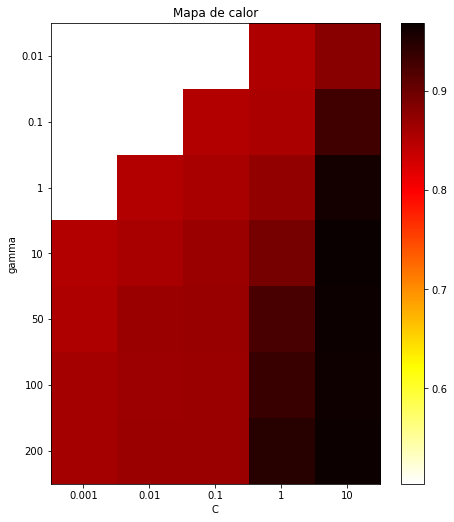

In [10]:
# Obtener todos los resultados decada una de las combinaciones de parámetros
r = svm_grid.cv_results_['mean_test_score'].reshape(len(parametros['C']),len(parametros['gamma']))

# Graficar
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(r, cmap='hot_r')
plt.xlabel('C')
plt.ylabel('gamma')
plt.colorbar()
plt.yticks(np.arange(len(parametros['C'])), parametros['C'])
plt.xticks(np.arange(len(parametros['gamma'])), parametros['gamma'])
plt.title('Mapa de calor')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

La precisión del modelo es 0.979381443298969


,Predicción 0,Predicción 1
Real 0,95,2
Real 1,4,99


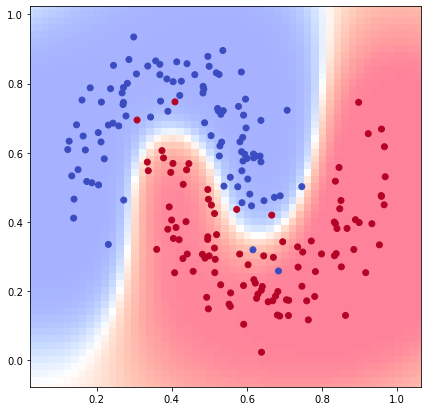

In [11]:
# Instanciar SVM con la mejor combinación de parámetros
svmc = svm.SVC(C = svm_grid.best_params_['C'], gamma = svm_grid.best_params_['gamma'], probability=True)

# Entrenar con los datos de train
svmc.fit(X_train, y_train)

# Graficar fronteras de decisión
test = pd.DataFrame(X_test)
plot_decision_boundaries(test[0], test[1], y_test, svmc,
                         x_max=max(test[0]) + 0.1,
                         x_min=min(test[0]) - 0.1,
                         y_max=max(test[1]) + 0.1,
                         y_min=min(test[1]) - 0.1
                        )

# Obtener predicción con los datos de test y evaluar
p = svmc.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, p), ['Real 0', 'Real 1'], ['Predicción 0', 'Predicción 1'])
print('La precisión del modelo es', cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1]))
cm

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532><b><i>SVM</b></i> ha conseguido clasificar acertadamente la mayor parte de los datos de <i>test</i>.<br>

<font color=#679532>En cuanto a la frontera de decisión, su geometría se adapta a la de los datos de forma que puede dividir las dos clases. También se puede ver la zona de incertidumbre, que es más regular y está mejor definida que con el método <i>knn</i>, especialmente en los cambios de pendiente de la frontera de decisión. Sin embargo, pese a no ser tan irregular, no está tan acotada, ya que encontramos zonas de incertidumbre lejos de la frontera de decisión.
</div>

### 1.3. Árboles de decisión (1 punto)

En este tercer ejercicio, clasificaremos los puntos utilizando un árbol de decisión. Utilizaremos como antes *grid search* para ajustar los hiperparámetros. En este caso ajustaremos los siguientes:

- max_depth: la profundidad máxima del árbol. Exploraremos los valores entre 4 y 10. 
- min_samples_split: el mínimo número de observaciones que ha de tener una hoja del árbol para poderse dividir. Exploraremos los valores: 2, 10, 20, 50 y 100.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>max_depth</i> y <i>min_samples_split</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y DecisionTreeClassifier de sklearn.
</div>

In [12]:
# Instanciar el árbol de decisión y establecer rango de parámetros
dt = DecisionTreeClassifier()
parametros = {
    'max_depth':list(range(4, 11)),
    'min_samples_split':[2, 10, 20, 50, 100]
}

# Instanciar GridSearch con el rango de parámetros definido y ajustar
dt_grid = GridSearchCV(dt, parametros, cv = 4)
dt_grid.fit(X_train, y_train)

# Obtener mejor combinación de parámetros
print('La mejor pareja de parámetros es:\nmax_depth =', dt_grid.best_params_['max_depth'],
      '\nmin_samples_split =', dt_grid.best_params_['min_samples_split']
     )

La mejor pareja de parámetros es:
max_depth = 5 
min_samples_split = 2


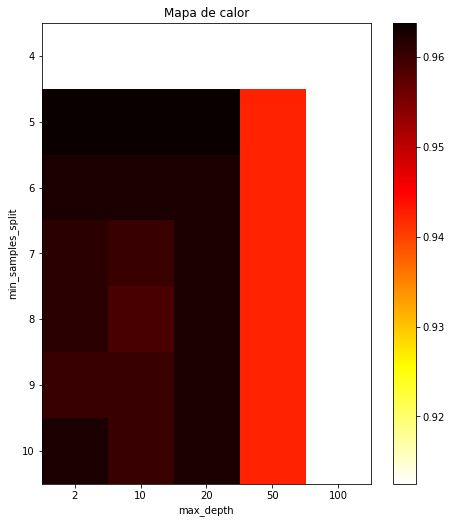

In [13]:
# Obtener todos los resultados decada una de las combinaciones de parámetros
r = dt_grid.cv_results_['mean_test_score'].reshape(len(parametros['max_depth']),len(parametros['min_samples_split']))

# Graficar
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(r, cmap='hot_r')
plt.xlabel('max_depth')
plt.ylabel('min_samples_split')
plt.colorbar()
plt.yticks(np.arange(len(parametros['max_depth'])), parametros['max_depth'])
plt.xticks(np.arange(len(parametros['min_samples_split'])), parametros['min_samples_split'])
plt.title('Mapa de calor')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

La precisión del modelo es 0.9587628865979382


,Predicción 0,Predicción 1
Real 0,93,4
Real 1,5,98


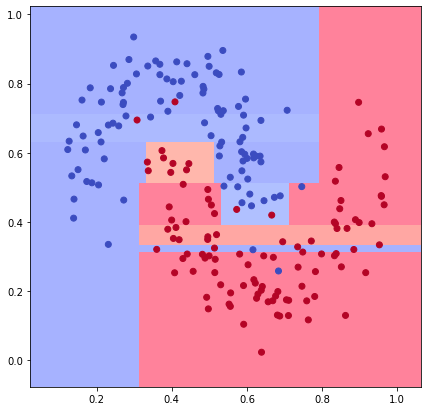

In [14]:
# Instanciar el árbol de decisión con la mejor combinación de parámetros
dt = DecisionTreeClassifier(max_depth = dt_grid.best_params_['max_depth'],
                            min_samples_split = dt_grid.best_params_['min_samples_split']
                           )

# Entrenar con los datos de train
dt.fit(X_train, y_train)

# Graficar fronteras de decisión
test = pd.DataFrame(X_test)
plot_decision_boundaries(test[0], test[1], y_test, dt,
                         x_max=max(test[0]) + 0.1,
                         x_min=min(test[0]) - 0.1,
                         y_max=max(test[1]) + 0.1,
                         y_min=min(test[1]) - 0.1
                        )

# Obtener predicción con los datos de test y evaluar
p = dt.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, p), ['Real 0', 'Real 1'], ['Predicción 0', 'Predicción 1'])
print('La precisión del modelo es', cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1]))
cm

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>El <b>árbol de decisión</b> ha conseguido clasificar acertadamente la mayor parte de los datos de <i>test</i>.<br>

<font color=#679532>En cuanto a la frontera de decisión, su geometría, pese a ser más tosca, se adapta a la de los datos de forma que puede dividir las dos clases. También se aprecia que está definida de froma menos difusa que con los anteriores métodos, pero se presenta de forma poco intuitiva en los cambios de pendiente. Se pueden observar algunas líneas de incertidumbre fuera de la frontera de decisión, mientras que en los casos anteriores la zona de incertidumbre y la frontera de decisión coincidían.
</div>

### 1.4. Random forest (1 punto)

En este cuarto ejercicio, clasificaremos los puntos utilizando Random forest. Utilizaremos, como hasta ahora, *grid search* para ajustar los hiperparámetros y ajustaremos:

- max_depth: la profundidad máxima del árbol. Exploraremos los valores comprendidos entre 6 y 12. 
- n_estimators: número de árboles. Exploraremos los valores: 10, 50, 100 y 200.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>max_depth</i> y <i>n_estimators</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y RandomForestClassifier de sklearn.
</div>

In [15]:
# Instanciar el random forest y establecer rango de parámetros
rf = RandomForestClassifier()
parametros = {
    'max_depth':list(range(6, 13)),
    'n_estimators':[10, 50, 100, 200]
}

# Instanciar GridSearch con el rango de parámetros definido y ajustar
rf_grid = GridSearchCV(rf, parametros, cv = 4)
rf_grid.fit(X_train, y_train)

# Obtener mejor combinación de parámetros
print('La mejor pareja de parámetros es:\nmax_depth =', rf_grid.best_params_['max_depth'],
      '\nn_estimators =', rf_grid.best_params_['n_estimators']
     )

La mejor pareja de parámetros es:
max_depth = 12 
n_estimators = 100


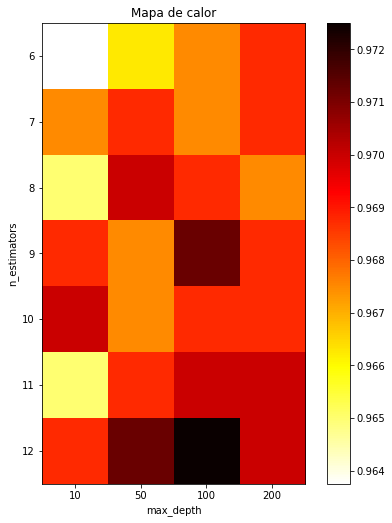

In [16]:
# Obtener todos los resultados decada una de las combinaciones de parámetros
r = rf_grid.cv_results_['mean_test_score'].reshape(len(parametros['max_depth']),len(parametros['n_estimators']))

# Graficar
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(r, cmap='hot_r')
plt.xlabel('max_depth')
plt.ylabel('n_estimators')
plt.colorbar()
plt.yticks(np.arange(len(parametros['max_depth'])), parametros['max_depth'])
plt.xticks(np.arange(len(parametros['n_estimators'])), parametros['n_estimators'])
plt.title('Mapa de calor')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

La precisión del modelo es 0.9690721649484536


,Predicción 0,Predicción 1
Real 0,94,3
Real 1,5,98


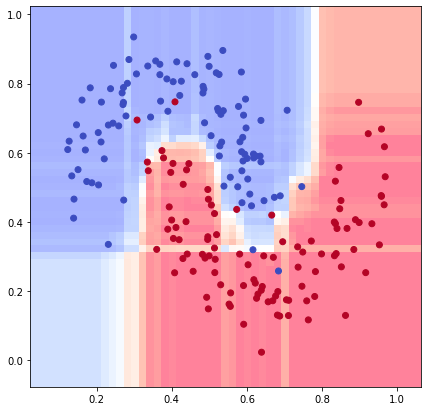

In [17]:
# Instanciar el random forest con la mejor combinación de parámetros
rf = RandomForestClassifier(max_depth = rf_grid.best_params_['max_depth'],
                            n_estimators = rf_grid.best_params_['n_estimators']
                           )

# Entrenar con los datos de train
rf.fit(X_train, y_train)

# Graficar fronteras de decisión
test = pd.DataFrame(X_test)
plot_decision_boundaries(test[0], test[1], y_test, rf,
                         x_max=max(test[0]) + 0.1,
                         x_min=min(test[0]) - 0.1,
                         y_max=max(test[1]) + 0.1,
                         y_min=min(test[1]) - 0.1
                        )

# Obtener predicción con los datos de test y evaluar
p = rf.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, p), ['Real 0', 'Real 1'], ['Predicción 0', 'Predicción 1'])
print('La precisión del modelo es', cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1]))
cm

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>El <b><i>random forest</b></i> ha conseguido clasificar acertadamente la mayor parte de los datos de <i>test</i>.<br>

<font color=#679532>En cuanto a la frontera de decisión, su geometría se adapta a la de los datos de forma que puede dividir las dos clases. Se puede apreciar que es muy similar a la obtenida en el árbol de decisión, solo que no está tan definida. Otra diferencia con respecto a la obternida en el árbol de decisión es que la zona de incertidumbre se encuentra en la frontera de decisión. Sin embargo, ésta también se presenta en varias zonas fuera de la frontera.
</div>

### 1.5. Gradient boosting (1 punto)

En este ejercicio clasificaremos los puntos utilizando Gradient boosting. Emplearemos como hasta ahora *grid search* para ajustar los siguientes hiperparámetros:

- learning_rate: velocidad de aprendizaje. Si su valor es muy alto, correremos el riesgo de no encontrar el valor óptimo por más que el algoritmo busque; mientras que si el valor es muy bajo, éste puede tardar mucho en converger y estancarse en un mínimo local. Exploraremos los valores: 0.01, 0.1, 1 y 2. 
- n_estimators: número de árboles. Exploraremos los valores: 10, 50, 100 y 200.

Igual que en los casos anteriores, utilizaremos validación cruzada (*cross-validation*) con 4 particiones estratificadas para validar el rendimiento del algoritmo con cada combinación de hiperparámetros.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> calcula el valor óptimo de los hiperparámetros <i>learning_rate</i> y <i>n_estimators</i>. Haz un <i>heatmap</i> para visualizar las precisiones de cada combinación según los dos hiperparámetros. Puedes utilizar los módulos GridSearchCV y GradientBoostingClassifier de sklearn.
</div>

In [18]:
# Instanciar el gradient boosting y establecer rango de parámetros
gb = GradientBoostingClassifier()
parametros = {
    'learning_rate':[0.01, 0.1, 1, 2],
    'n_estimators':[10, 50, 100, 200]
}

# Instanciar GridSearch con el rango de parámetros definido y ajustar
gb_grid = GridSearchCV(gb, parametros, cv = 4)
gb_grid.fit(X_train, y_train)

# Obtener mejor combinación de parámetros
print('La mejor pareja de parámetros es:\nlearning_rate =', gb_grid.best_params_['learning_rate'],
      '\nn_estimators =', gb_grid.best_params_['n_estimators']
     )

La mejor pareja de parámetros es:
learning_rate = 0.1 
n_estimators = 100


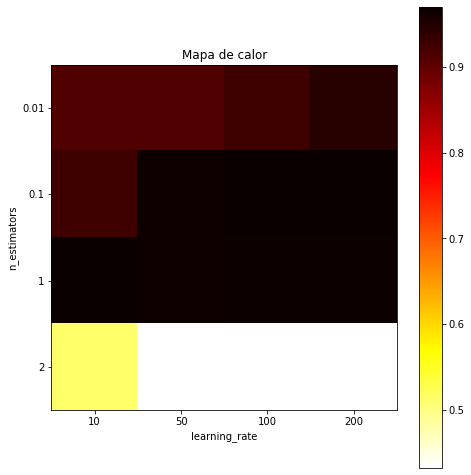

In [19]:
# Obtener todos los resultados decada una de las combinaciones de parámetros
r = gb_grid.cv_results_['mean_test_score'].reshape(len(parametros['learning_rate']),len(parametros['n_estimators']))

# Graficar
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(r, cmap='hot_r')
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.yticks(np.arange(len(parametros['learning_rate'])), parametros['learning_rate'])
plt.xticks(np.arange(len(parametros['n_estimators'])), parametros['n_estimators'])
plt.title('Mapa de calor')
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> usando los hiperparámetros con mayor precisión, representa gráficamente la frontera de decisión con el <i>dataset</i> de test y calcula su <i>accuracy</i> y su matriz de confusión. 
</div>

La precisión del modelo es 0.9690721649484536


,Predicción 0,Predicción 1
Real 0,94,3
Real 1,6,97


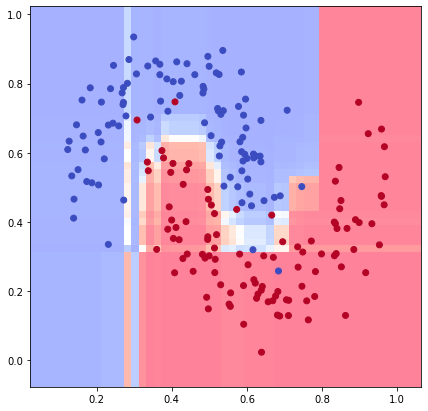

In [20]:
# Instanciar el gradient boosting con la mejor combinación de parámetros
gb = GradientBoostingClassifier(learning_rate = gb_grid.best_params_['learning_rate'],
                                n_estimators = gb_grid.best_params_['n_estimators']
                               )

# Entrenar con los datos de train
gb.fit(X_train, y_train)

# Graficar fronteras de decisión
test = pd.DataFrame(X_test)
plot_decision_boundaries(test[0], test[1], y_test, gb,
                         x_max=max(test[0]) + 0.1,
                         x_min=min(test[0]) - 0.1,
                         y_max=max(test[1]) + 0.1,
                         y_min=min(test[1]) - 0.1
                        )

# Obtener predicción con los datos de test y evaluar
p = gb.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, p), ['Real 0', 'Real 1'], ['Predicción 0', 'Predicción 1'])
print('La precisión del modelo es', cm.iloc[0,0] / (cm.iloc[0,0] + cm.iloc[0,1]))
cm

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> analiza los resultados obtenidos y en especial la frontera de descisión.
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>El <b><i>gradient boosting</b></i> ha conseguido clasificar correctamente la mayor parte de los datos de <i>test</i>.<br>

<font color=#679532>En cuanto a la frontera de decisión, su geometría se adapta a la de los datos de forma que puede dividir las dos clases. Se puede apreciar que es muy similar a las obtenidas en el árbol de decisión y el <i>random forest</i>. Sin embargo, se encuentra más definida que en este último, y su zona de incertidumbre está mucho más contenida en la frontera de decisión de forma más acotada y mejor definida.
</div>

# 2. Implementación de un caso práctico (5 puntos)

Ahora que ya entendemos cómo funcionan algunos modelos, vamos a aplicarlos a un caso práctico. La primera mitad de la práctica se ha realizado utilizando una variable objetivo categórica, para esta segunda mitad emplearemos una variable objetivo numérica. Es decir, trabajaremos con un problema de regresión, no de clasificación.

Utilizaremos un conjunto de datos público de precios de viviendas en Taiwán con el objetivo de encontrar las mejores ofertas del mercado. La descripción completa del conjunto de datos la podemos encontrar en el siguiente enlace: https://archive.ics.uci.edu/ml/datasets/Real+estate+valuation+data+set

Comencemos cargando los datos en un DataFrame de pandas:

In [21]:
dataset = pd.read_excel('Real estate valuation data set.xlsx', engine='openpyxl')

dataset.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


La primera columna ("*No*") es el identificador numérico de la muestra. Las columnes "*Xn ...*" son los diferentes atributos descriptivos. Finalmente, la columna "*Y ...*" es el valor objetivo o precio de la vivienda.

Extraemos del *DataFrame* la variable objetivo y los atributos descriptivos que utilizaremos posteriormente en el modelo predictivo:

In [22]:
X = dataset[[
    'X2 house age',
    'X3 distance to the nearest MRT station',
    'X4 number of convenience stores',
    'X5 latitude',
    'X6 longitude'
]]

y = dataset['Y house price of unit area']

### 2.1. Análisis descriptivo
Cuando se nos proporciona un dataset, antes de comenzar a hacer nada, es muy importante hacer un análisis exploratorio para conocer los datos con los que trabajaremos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> analizar gráficamente la distribución de todas las variables (features y target). Recuerda que las variables categóricass se representan con gráficas de barras, mientras que las numéricas se representan con histogramas.
</div>

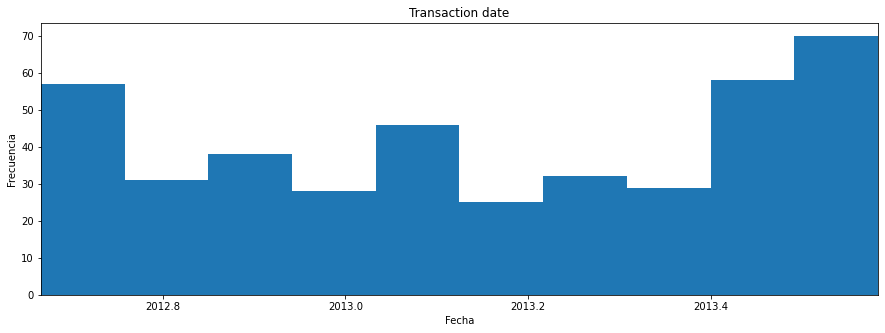

In [23]:
# Graficar transaction date
variable = dataset['X1 transaction date']
valor = 'Fecha'
titulo = 'Transaction date'

plt.figure(figsize=(15, 5))
plt.hist(variable)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xlim(min(variable), max(variable))
plt.show()

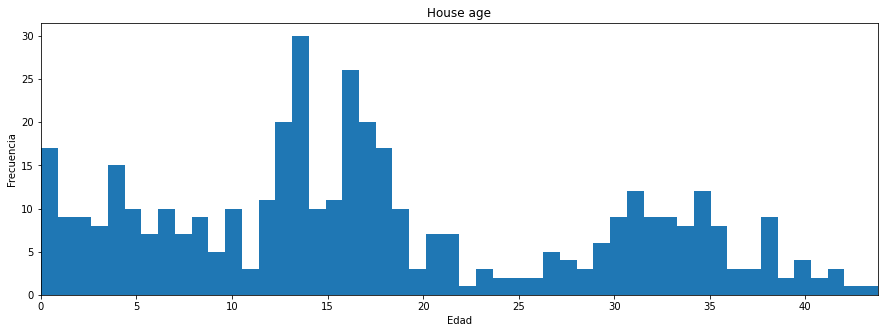

In [24]:
# Graficar house age
variable = dataset['X2 house age']
valor = 'Edad'
titulo = 'House age'

plt.figure(figsize=(15, 5))
plt.hist(variable, bins=50)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xlim(min(variable), max(variable))
plt.show()

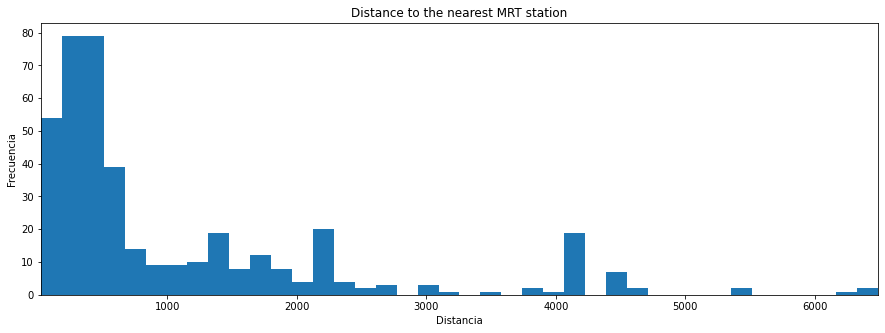

In [25]:
# Graficar distance to the nearest MRT station
variable = dataset['X3 distance to the nearest MRT station']
valor = 'Distancia'
titulo = 'Distance to the nearest MRT station'

plt.figure(figsize=(15, 5))
plt.hist(variable, bins=40)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xlim(min(variable), max(variable))
plt.show()

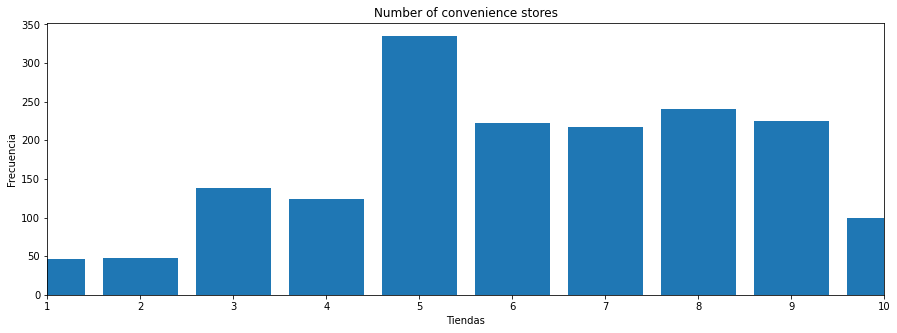

In [26]:
# Graficar number of convenience stores
variable = dataset['X4 number of convenience stores']
valor = 'Tiendas'
titulo = 'Number of convenience stores'

f = []
for i in np.sort(variable.unique()):
    if i!=0:
        f.append(sum(variable[variable==i]))

plt.figure(figsize=(15, 5))
plt.bar(range(1,11), f)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xticks(range(1,11))
plt.xlim(1, 10)
plt.show()

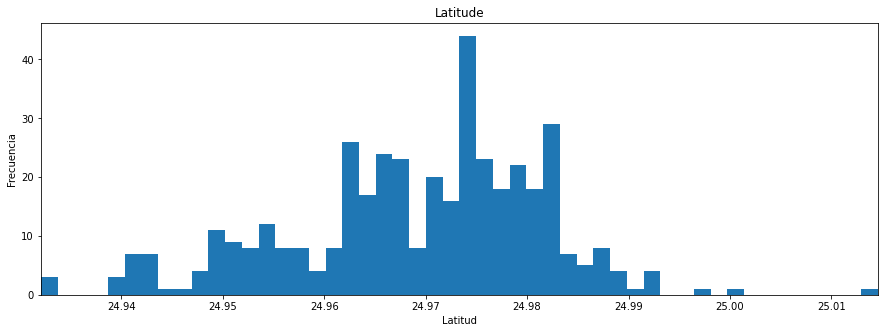

In [27]:
# Graficar latitude
variable = dataset['X5 latitude']
valor = 'Latitud'
titulo = 'Latitude'

plt.figure(figsize=(15, 5))
plt.hist(variable, bins=50)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xlim(min(variable), max(variable))
plt.show()

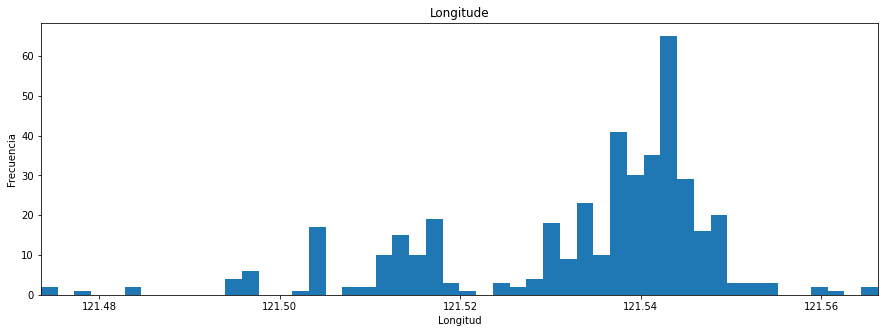

In [28]:
# Graficar longitude
variable = dataset['X6 longitude']
valor = 'Longitud'
titulo = 'Longitude'

plt.figure(figsize=(15, 5))
plt.hist(variable, bins=50)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xlim(min(variable), max(variable))
plt.show()

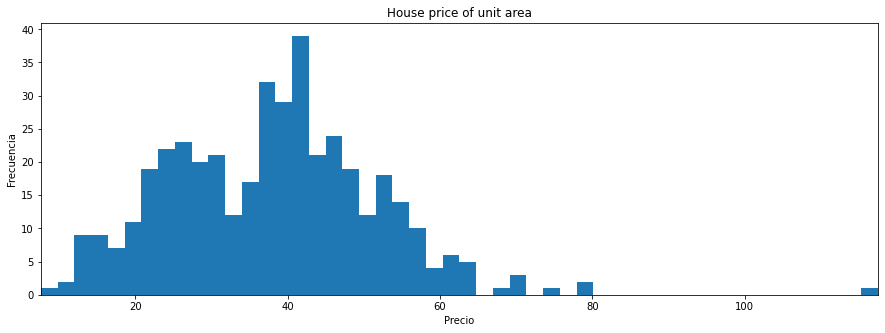

In [29]:
# Graficar house price of unit area
variable = dataset['Y house price of unit area']
valor = 'Precio'
titulo = 'House price of unit area'

plt.figure(figsize=(15, 5))
plt.hist(variable, bins=50)
plt.title(titulo)
plt.ylabel('Frecuencia')
plt.xlabel(valor)
plt.xlim(min(variable), max(variable))
plt.show()

### 2.2. Preprocesamiento de los datos

Una vez hecho un primer análisis, se trata de "limpiar" el dataset (las features) y adaptarlo a nuestras necesidades (en este caso, predecir el precio de una vivienda).

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> comprueba si hay valores nulos. En caso de haberlos, elimina las filas correspondientes.
</div>

In [30]:
# Comprobar si hay valores nulos o vacíos
X.isnull().any(skipna = False)

X2 house age                              False
X3 distance to the nearest MRT station    False
X4 number of convenience stores           False
X5 latitude                               False
X6 longitude                              False
dtype: bool

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>
    
<font color=#679532>No hay valores nulos ni vacíos.
</div>

El siguiente paso sería estudiar la correlación entre todas las variables descriptivas (features) numéricas. Esto se hace para asegurarse de que no hay dos variables muy relacionadas entre sí, ya que en tal caso sería conveniente seleccionar una de las dos o combinarlas en una nueva para reducir dimensionalidad.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> muestra la correlación entre todas las features numéricas. Si hay dos con una correlación superior al 90%, elimina una de ellas.
    
Puedes utilizar heatmap, de seaborn, para verlas en un mapa de colores.
</div>

In [31]:
# Obtener la matriz de correlación con todos los atributos numéricos
X.loc[:, X.columns!='X4 number of convenience stores'].corr()

,X2 house age,X3 distance to the nearest MRT station,X5 latitude,X6 longitude
X2 house age,1.000000,0.025622,0.054420,-0.048520
X3 distance to the nearest MRT station,0.025622,1.000000,-0.591067,-0.806317
X5 latitude,0.054420,-0.591067,1.000000,0.412924
X6 longitude,-0.048520,-0.806317,0.412924,1.000000


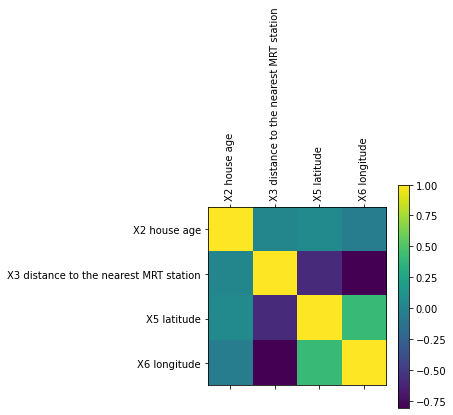

In [32]:
# Generar mapa de calor a partir de la matriz de correlación
plt.matshow(X.loc[:, X.columns!='X4 number of convenience stores'].corr())
plt.xticks(range(X.loc[:, X.columns!='X4 number of convenience stores'].corr().select_dtypes(['number']).shape[1]),
           X.loc[:, X.columns!='X4 number of convenience stores'].corr().select_dtypes(['number']).columns,
           rotation=90
          )
plt.yticks(range(X.loc[:, X.columns!='X4 number of convenience stores'].corr().select_dtypes(['number']).shape[1]),
           X.loc[:, X.columns!='X4 number of convenience stores'].corr().select_dtypes(['number']).columns
          )
plt.colorbar()
plt.show()

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>No hay ninguna pareja de atributos con una correlación superior al 90%.
</div>

Ya tenemos las variables finales con las que trabajaremos. Vamos a observar ahora cuál es la relación de cada una de ellas con el target.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> realiza varios scatterplots cruzando los diferentes atributos descriptivos con la variable target. Se ha de realizar un scatterplot por atributo.
</div>

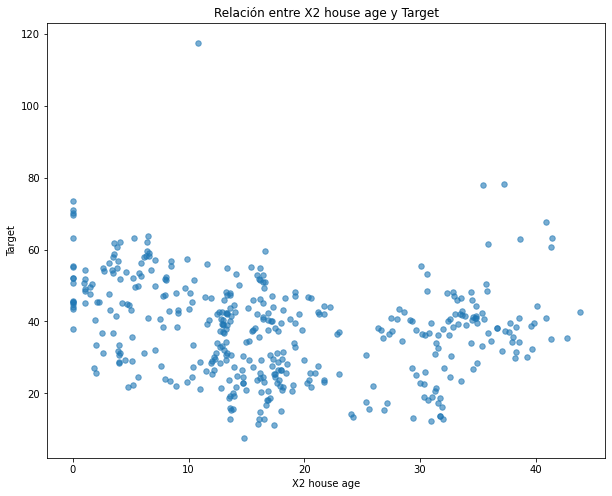

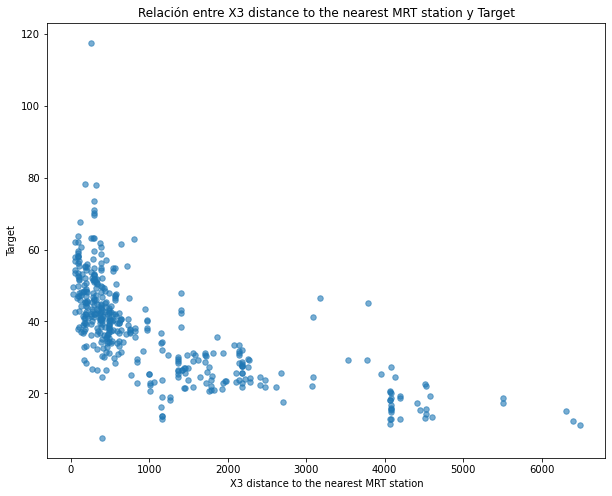

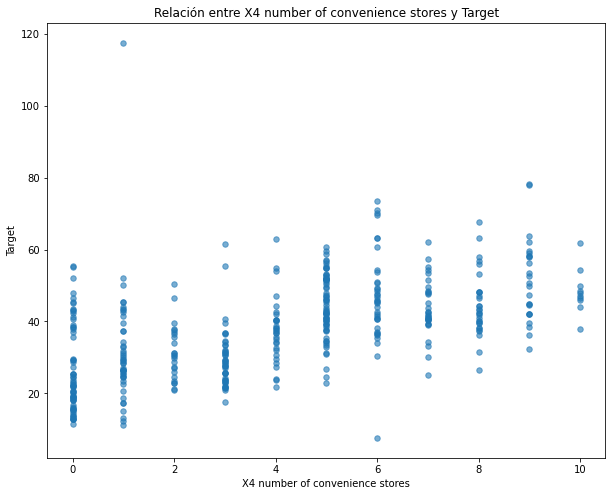

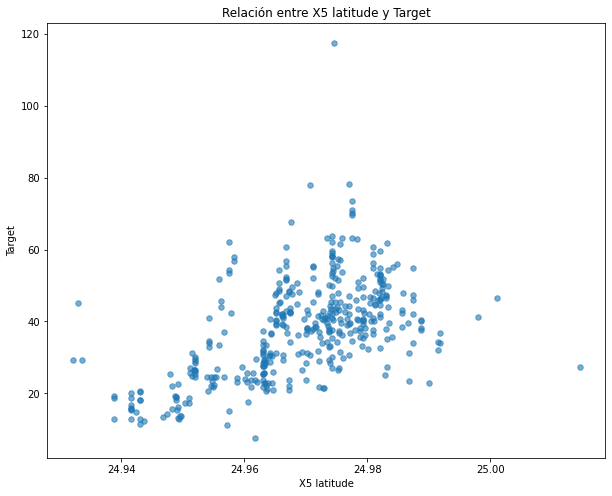

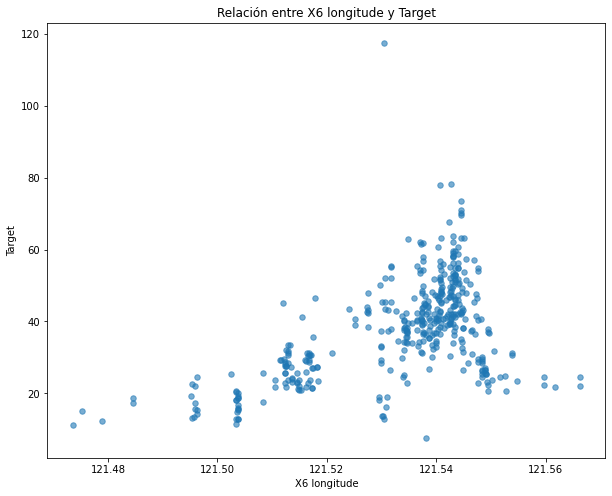

In [33]:
# Graficar por cada atributo
for i in X:
    plt.figure(figsize=(10, 8))
    plt.title('Relación entre {} y Target'.format(i))
    plt.ylabel('Target')
    plt.xlabel(i)
    plt.scatter(X[i], y, s=30, alpha=.6, cmap='jet')
    plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿qué atributos tienen correlación positiva? ¿Cuáles negativa? ¿Cuáles no tienen ninguna correlación? Analiza cada uno de los gráficos. ¿Tiene sentido que la relación de cada atributo con el target sea la encontrada?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>Las parejas de atributos con <b>correlación positiva</b> son:<br>

- <font color=#679532><i><b>X5</b> latitude</i> <b><-></b> <i><b>X6</b> longitude</i><br>

<font color=#679532>Las parejas de atributos con **correlación negativa** son:<br>

- <font color=#679532><i><b>X3</b> distance to the nearest MRT station</i> <b><-></b> <i><b>X5</b> latitude</i><br>
- <font color=#679532><i><b>X3</b> distance to the nearest MRT station</i> <b><-></b> <i><b>X6</b> longitude</i><br>

<font color=#679532>Las parejas de atributos con <b>correlación cercana a <i>0</i></b>:<br>

- <font color=#679532><i><b>X2</b> house age</i> <b><-></b> <i><b>X3</b> londistance to the nearest MRT stationgitude</i><br>
- <font color=#679532><i><b>X2</b> house age</i> <b><-></b> <i><b>X5</b> latitude</i><br>
- <font color=#679532><i><b>X2</b> house age</i> <b><-></b> <i><b>X6</b> longitude</i><br>

<hr>

<font color=#679532><b>Relación entre <i>X2 house age</i> y <i>Target</i></b>: No existe una relación muy clara en este caso. Quizá se puede intuir una forma parabólica en los datos, donde los precios aumentan según te acercas a los extremos de la edad de las casas: si la casa es muy nueva o muy antigua, más probabilidad de que el precio sea más alto; si la casa se encuentra en torno a una edad moderada (20 - 25 años), mas probabilidades de se su precio sea más bajo. Sin embargo, esta relación no es muy clara.<br>

<font color=#679532><b>Sentido</b>: Esta tendencia tiene cierto sentido ya que es lógico pensar que las viviendas nuevas están mejor equipadas y son de mejor calidad, teniendo un precio mayor que las que se contruyeron hace alrededor de 20 años. Sin embargo, también tiene sentido deducir que las casas que superan este umbral y han sobrevivido al paso de los años tengan un precio mayor. Esto es debido a que tienen un valor añadido que ha hecho que los propietarios las mantengan, cuiden e incluso reformen  para que sean habitables más tiempo que la media. Ese valor especial (que puede deberse a su ubicación, historia, fama, etc.), junto a la inversión extra para prolongar su tiempo de vida, hace que su precio también aumente.<br>
    
<hr>
<font color=#679532><b>Relación entre <i>X3 distance to the nearest MRT station</i> y <i>Target</i></b>: Esta variable sí muestra una relación algo más clara, parecida a una exponencial decreciente; esto es, a medida que la distancia entre la vivienda y la estación de MRT más cercana disminuye, su precio aumenta exponencialmente.<br>

<font color=#679532><b>Sentido</b>: Esta relación es muy intuitiva ya que la cercanía a una estación de transporte de masas es de gran valor añadido para las viviendas, siendo las que se encuentran a menor distancia mucho más valoradas por los clientes que las que se encuentran más alejadas.<br>

<hr>
<font color=#679532><b>Relación entre <i>X4 number of convenience stores</i> y <i>Target</i></b>: Se puede apreciar un ligero aumento del precio medio a medida que aumenta el número de tiendas cerca de la vivienda, estancándose e incluso disminuyendo ligeramente su precio a partir de <i>6</i> tiendas. Sin emnargo, esta relación no es clara y existen muchos <i>outliers</i> alejados de esta tendencia.<br>

<font color=#679532><b>Sentido</b>: A esta relación se le puede encontrar cierta lógica argumentando que, a menor número de tiendas cercanas a la vivienda, más alejada es la zona en la que se sitúa y, por tanto, menos valoración general de la misma. También se puede argumentar que el hecho de que el número de tiendas sea excesivo (><i>6</i>) puede ser un indicador de una zona localizadamente saturada y céntrica, que en ocasiones puede tener incluso ciertos aspectos de suburbio.<br>

<hr>
<font color=#679532><b>Relación entre <i>X5 latitude</i> y <i>Target</i></b>: Existe también una tendencia de aumento del precio a medida que aumenta la latitud de la casa. No obstante, las pocas viviendas cuya latitud es más elevada (aprox. ><i>25</i>) se mantienen con un precio relativamente bajo.<br>

<font color=#679532><b>Sentido</b>: Sin conocer nada más acerca de los datos, no se puede deducir un sentido lógico a esta relación. Sin embargo, analizando la zona de donde se han recogido los datos, la latitud de las viviendas más caras corresponde a la zona norte del distrito de Xindian, donde se encuentran estaciones de tren, centros deportivos, zonas de restauración, etc., mientras que la zona sur (latitudes más bajas) tiene mayor densidad de viviendas y menor variedad de zonas como las mencionadas.<br>

<hr>
<font color=#679532><b>Relación entre <i>X6 longitude</i> y <i>Target</i></b>: Igual que en el caso anterior, solo que esta vez los <i>outliers</i> con mayor longitud en sus coordenadas son menores y no están tan alejados de la media de la distribución.<br>

<font color=#679532><b>Sentido</b>: Ocurre lo mismo que en el caso anterior. La zona más al este del distrito de Xindian (longitudes mayores) se trata del núcleo urbano con centros educativos, supermercados, etc. Más al oeste de esta zona (longitudes más bajas), la centricidad de las viviendas es menor, llegando incluso a cruzar el río que divide la ciudad, incomunicando mayormente las viviendas que se sitúan en esa zona.
</div>

### 2.3. Entrenamiento de un modelo

Ahora que ya tenemos el dataset limpio y hemos hecho un análisis de las diferentes variables, podemos proceder a entrenar un modelo para predecir el precio de una vivienda. Probaremos con 2 modelos diferentes e interpretaremos sus resultados. Para comenzar, separemos el dataset en train y test.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> divide el <i>dataset</i> en dos subconjuntos, <i>train</i> (80% de los datos) y <i>test</i> (20% restante). Nombraremos los conjuntos: X_train, X_test, y_train e y_test. Utilizaremos la opción random_state=24.
    
Puedes servirte de la implementación <i>train_test_split</i> de <i>sklearn</i>.
</div>

In [34]:
# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8,
                                                    random_state = 24
                                                   )
# Instanciar normalizador
normalizar = preprocessing.MinMaxScaler()

# Ajustar y normalizar
X_train = normalizar.fit_transform(X_train)

# Normalizar con los parámetros obtenidos de la normalización de los datos de train
X_test = normalizar.transform(X_test)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> utiliza un árbol de decisión simple con max_depth=5 para modelar el dataset sobre el conjunto de train. Dibuja el árbol de decisión. Si te queda muy grande, dibuja un árbol entrenado con menor profundidad para que puedas apreciarlo mejor. Utiliza alguna medida de error (puedes escoger la que quieras: MAE, RMSE, ...) para estimar cómo de bien lo ha hecho el modelo prediciedo en train y en test. También servirá para poder comparar a posteriori con otro modelo.
    
Para dibujar el árbol puedes guiarte con este enlace: https://towardsdatascience.com/visualizing-decision-trees-with-python-scikit-learn-graphviz-matplotlib-1c50b4aa68dc. Towardsdatascience es un blog que te deja leer unos cuantos artículos gratuitamente y despues te pide subscripción. Si fuera el caso y ya hubieras llegado al límite, puedes abrir el enlace en una pestaña de navegación privada.
</div>

TRAIN: MAPE = 0.10890260290687549
TEST: MAPE = 0.13103251420489628


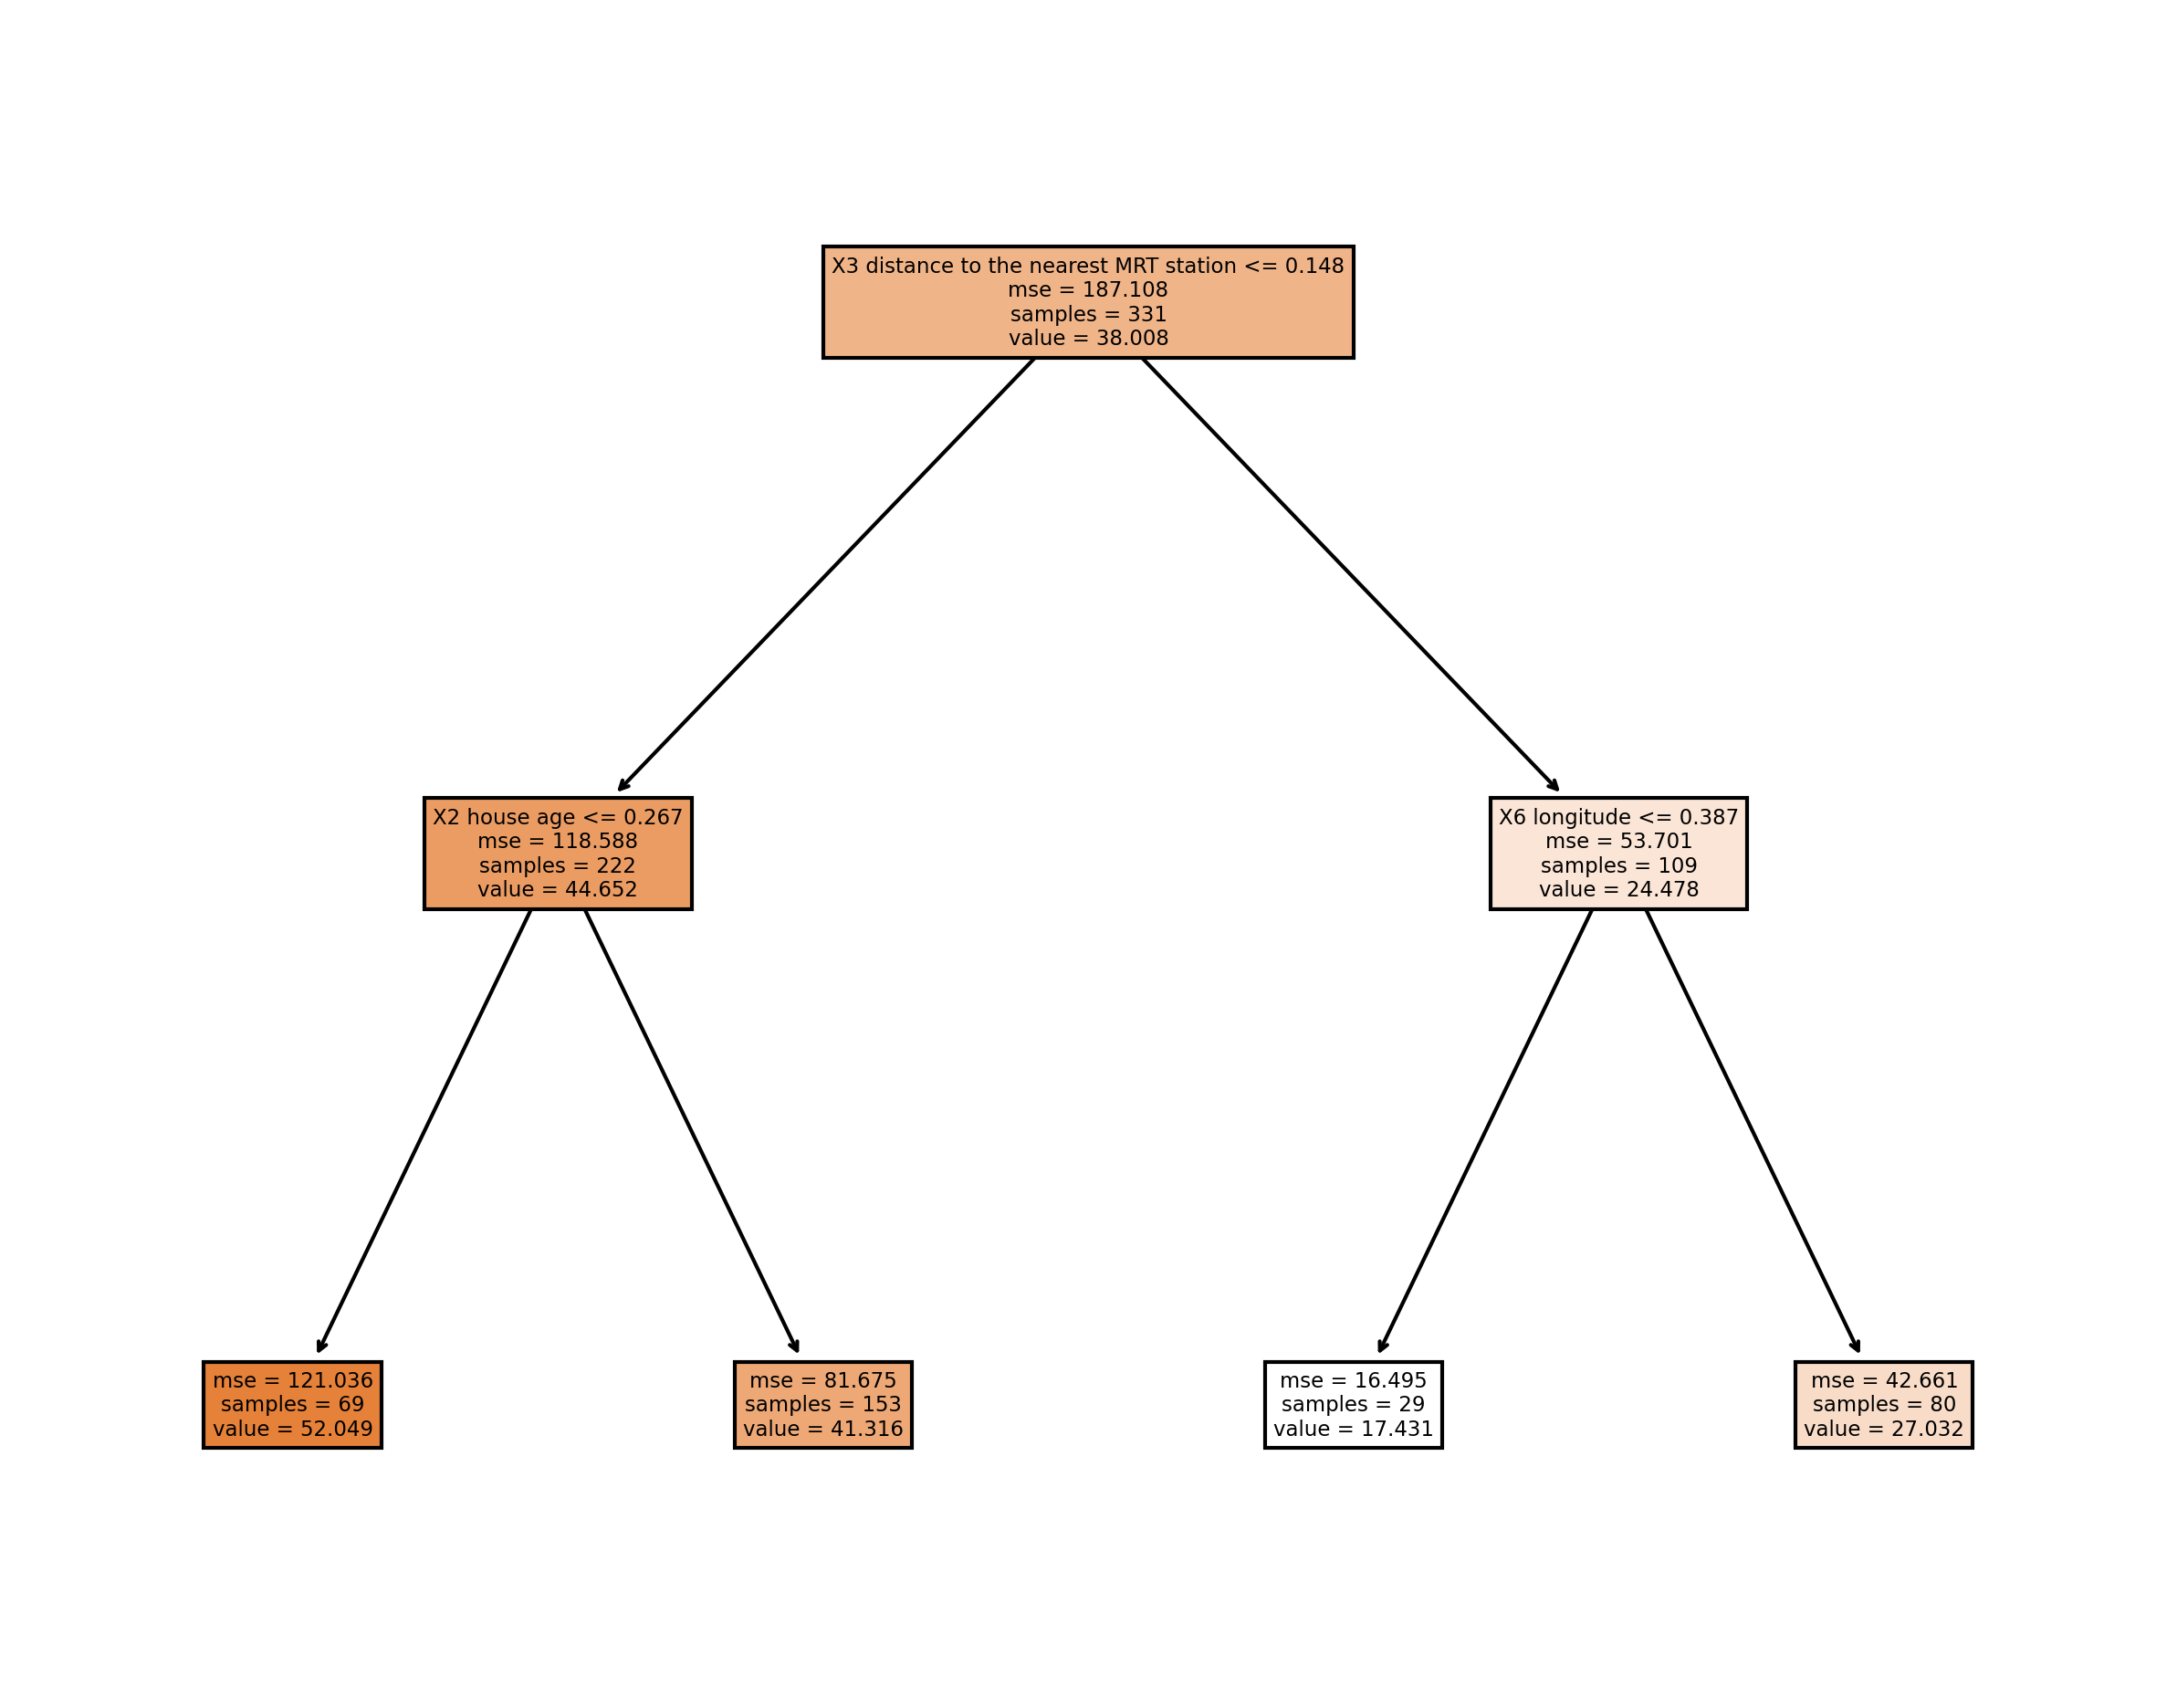

In [35]:
from sklearn.tree import plot_tree

# Generar modelo
dt = DecisionTreeRegressor(max_depth=5)               # Árbol para predecir
dtgraf = DecisionTreeRegressor(max_depth=2)           # Árbol solo para generar un gráfico legible

# Ajustar el modelo con el conjunto de train
dt.fit(X_train, y_train)
dtgraf.fit(X_train, y_train)

# Representar gráficamente
plt.subplots(nrows = 1, ncols = 1,figsize = (10, 8), dpi=300)
plot_tree(dtgraf, feature_names = X.columns, filled = True);

# Obtener predicción con los datos de train y evaluar
p = dt.predict(X_train)
print('TRAIN: MAPE =', mean_absolute_percentage_error(y_train, p))

# Obtener predicción con los datos de test y evaluar
p = dt.predict(X_test)
print('TEST: MAPE =', mean_absolute_percentage_error(y_test, p))

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta el árbol de decisión, ¿qué variables son las que han tenido más peso? ¿Has obtenido una buena precisión evaluando en test? ¿Se ha producido overfitting?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>La primera partición la hace sobre todos los 331 registros del conjunto <i>train</i> basándose en la variable "<i><b>X3</b> distance to the nearest MRT station</i>" a partir del valor <i><b>0.148</b></i> (normalizado).<br>

<font color=#679532>Hay 222 registros cuyo valor de <i><b>X3</b></i> es menor o igual a este número. A éstos los divide según la variable <i><b>X2</b> house age</i> a partir del valor <i><b>0.267</b></i> (normalizado). Por otro lado, las 109 muestras con un valor superior a <i><b>0.148</b></i> (normalizado) en la variable <i><b>X3</b></i> se dividen a partir del valor <i><b>0.387</b></i> (normalizado) de <i><b>X6</b> longitude</i>; y así sucesivamente. Por lo tanto, las 3 variables con más peso son <i><b>X3</b></i>, <i><b>X2</b></i> y <i><b>X6</b></i>.<br>

<hr>
<font color=#679532>El error porcentual absoluto medio (<i>MAPE</i>) cometido por el árbol de decisión con los datos de entrenamiento ha sido de <b><i>0.10</i></b>, mientras que con los datos de <i>test</i> ha sido de <b><i>0.13</i></b> Es un resultado excelente ya que se ha logrado minimizar ostensiblemente el error cometido en la predicción sin cometer un <i>overfitting</i> palpable, ya que la diferencia entre los errores de los datos de <i>test</i> y <i>train</i> es muy pequeña, lo que indica que el modelo logra generalizar correctamente el parendizaje.
</div>

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> utiliza Random Forest o Gradient Boosting para modelar el dataset. Esta vez vamos a optimizar el modelo para obtener los mejores resultados posibles. Tal y como hemos visto anteriormente, recuerda seguir los siguientes pasos:
    
  - Utilizar el dataset de train para encontrar los mejores hiperparámetros haciendo cross-validation.
  - Entrenar el modelo con train, predecir con train y test y calcular el error (MAE, RMSE, ...)
</div>

In [36]:
# Instanciar el gradient boosting y establecer rango de parámetros
gb = GradientBoostingRegressor()
parametros = {
    'learning_rate':[0.01, 0.1, 1],
    'n_estimators':[10, 50, 100, 200]
}

# Instanciar GridSearch con el rango de parámetros definido, cross-validation=4 y ajustar
gb_grid = GridSearchCV(gb, parametros, cv = 4)
gb_grid.fit(X_train, y_train.ravel())

# Obtener mejor combinación de parámetros
print('La mejor pareja de parámetros es:\nlearning_rate =', gb_grid.best_params_['learning_rate'],
      '\nn_estimators =', gb_grid.best_params_['n_estimators']
     )

La mejor pareja de parámetros es:
learning_rate = 0.1 
n_estimators = 100


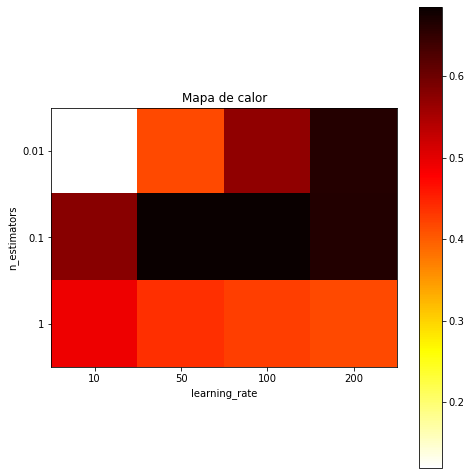

In [37]:
# Obtener todos los resultados decada una de las combinaciones de parámetros
r = gb_grid.cv_results_['mean_test_score'].reshape(len(parametros['learning_rate']),len(parametros['n_estimators']))

# Graficar
plt.figure(figsize=(8, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(r, cmap='hot_r')
plt.xlabel('learning_rate')
plt.ylabel('n_estimators')
plt.colorbar()
plt.yticks(np.arange(len(parametros['learning_rate'])), parametros['learning_rate'])
plt.xticks(np.arange(len(parametros['n_estimators'])), parametros['n_estimators'])
plt.title('Mapa de calor')
plt.show()

In [38]:
# Instanciar el gradient boosting con la mejor combinación de parámetros
gb = GradientBoostingRegressor(learning_rate = gb_grid.best_params_['learning_rate'],
                                n_estimators = gb_grid.best_params_['n_estimators']
                               )

# Entrenar con los datos de train
gb.fit(X_train, y_train.ravel())

# Obtener predicción con los datos de train y evaluar
p = gb.predict(X_train)
print('TRAIN: MAPE =', mean_absolute_percentage_error(y_train, p))

# Obtener predicción con los datos de test y evaluar
p = gb.predict(X_test)
print('TEST: MAPE =', mean_absolute_percentage_error(y_test, p))

TRAIN: MAPE = 0.08598022404745391
TEST: MAPE = 0.10975363479535662


Un Random Forest / Gradient Boosting no es tan fácil de interpretar como un simple Decision Tree. No podemos dibujar un árbol porque son combinaciones de muchos árboles, pero sí que podemos saber cuáles han sido las variables más decisivas a la hora de generar el modelo. Para saberlo, no podremos hacerlo mirando cómo se divide el árbol, sino que se lo tendremos que consultar al modelo através de la "feature importance" de éste.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> muestra cada variable del modelo aprendido junto con su feature importance.
</div>

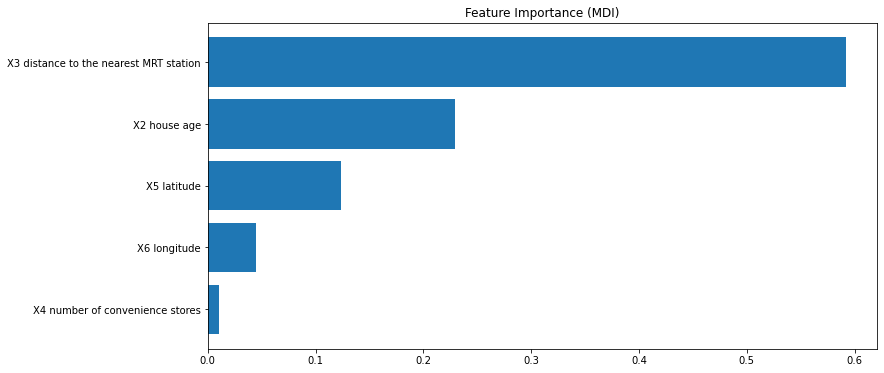

,X4 number of convenience stores,X6 longitude,X5 latitude,X2 house age,X3 distance to the nearest MRT station
Feature importance,0.010133,0.044993,0.123664,0.229632,0.591578


In [39]:
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Graficar la feature importance
feature_importance = gb.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.title("Feature Importance (MDI)")
plt.show()

# Mostrar valores exactos por cada atributo
mdi = pd.DataFrame([feature_importance[sorted_idx]], columns=X.columns[[sorted_idx]])
mdi.index = ['Feature importance']
mdi

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> interpreta el clasificador, ¿cuáles son las variables que han tenido más peso? ¿Has obtenido una buena precisión evaluando en test? ¿Se ha producido overfitting?
</div>

<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>La variable con más peso es, con diferencia, <i><b>X3</b> distance to the nearest MRT station</i>, seguida de <i><b>X2</b></i> y <i><b>X5</b></i><br>

<font color=#679532>La precisión ha mejorado la del árbol de decisión anterior, obteniendo un muy buen error porcentual absoluto medio (<i>MAPE</i>) de <i><b>0.08</b></i> con los datos de entrenamiento y <i><b>0.109</b></i> con los datos de <i>test</i>. La diferencia de rendimiento del modelo con los datos de <i>train</i> y <i>test</i> es incluso más pequeña que en el anterior modelo, por lo que no se ha producido <i>overfitting</i> en absoluto.
</div>

### 2.4. Predicción de casos nuevos

Hasta ahora hemos entrenado un modelo y hemos evaluado en test para hacernos una idea de la precisión de nuestro modelo con datos reales. Ahora vamos a utilizarlo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> 
    
  - Caso 1: queremos comprar una vivienda que está situada a 1km de la estación de tren, concretamente sus coordenadas son: 24.87745, 121.31683. La vivienda tiene 3 tiendas cerca y se construyó hace 15 años. Se vende por 24500€/m2 y queremos saber si está por encima o por debajo del precio de mercado.	
    
  - Caso 2: somos una empresa que se dedica a hacer negocio comprando pisos baratos, arreglándolos y volviéndolos a vender más caros. Queremos saber qué viviendas del conjunto de datos se venden por debajo de su precio de mercado ("chollos") para poder comprarlas y revenderlas en un futuro.
</div>

In [40]:
# Establecer los datos de las variables de la nueva instancia
new = pd.DataFrame({
    'X2' : [15],           # Años
    'X3' : [1000],         # Metros a estación
    'X4' : [3],            # Tiendas cercanas
    'X5' : [24.87745],     # Latitud
    'X6' : [121.31683],    # Longitud
}
)
precio = 23.268            # 10000TWD/ping (24500€/m*2)

# Normalizar con los parámetros obtenidos de la normalización de los datos de train
newnor = normalizar.transform(new)

# Predecir con el gradient boosting entrenado con los datos de train
prediccion = gb.predict(new)
print('Precio de venta:\t', precio, '\nPrecio de mercado:\t', prediccion[0])

Precio de venta:	 23.268 
Precio de mercado:	 32.475006418104854


<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>El valor predicho por el modelo (<i><b>32.47</b></i> x10000TWD/ping) según las características de la vivienda es mayor que el precio de venta (<i><b>23.26</b></i> x10000TWD/ping). Por lo tanto, el precio al que se vende se encuentra por debajo del precio de mercado.
</div>

In [41]:
# Normalizar con los parámetros obtenidos de la normalización de los datos de train
Xnor = normalizar.transform(X)

# Predecir todos los datos con el gradient boosting entrenado con los datos de train
prediccion = gb.predict(Xnor)

# Establecer y guardar chollos
chollos = []
for i in range(len(y)):
    if (prediccion[i] - y[i] > 0):
        chollos.append(X.loc[i])
chollos = pd.DataFrame(chollos)
chollos

,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude
0,32.0,84.87882,10.0,24.98298,121.54024
1,19.5,306.59470,9.0,24.98034,121.53951
4,5.0,390.56840,5.0,24.97937,121.54245
6,34.5,623.47310,7.0,24.97933,121.53642
7,20.3,287.60250,6.0,24.98042,121.54228
...,...,...,...,...,...
405,23.0,130.99450,6.0,24.95663,121.53765
406,1.9,372.13860,7.0,24.97293,121.54026
407,5.2,2408.99300,0.0,24.95505,121.55964
409,13.7,4082.01500,0.0,24.94155,121.50381


<div class="alert alert-block alert-success">
<strong>Respuesta:</strong><br>

<font color=#679532>Este <i>DataFrame</i> contiene los chollos del conjunto de datos, siendo éstos los registros cuyo valor real es menor que el valor de mercado predicho por el modelo.
</div>